In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import spateo as st
warnings.filterwarnings('ignore')

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packag

In [2]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyvista import PolyData, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

In [3]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_spateo/mouse_heart/figure6")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_h5ad_path = f"droso_{sample_id}_GBA_morpho/h5ad"
out_image_path = f"droso_{sample_id}_GBA_morpho/image/GBA_amnioserosa_curature"
Path(out_h5ad_path).mkdir(parents=True, exist_ok=True)
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [16]:
# Read anndata
key = "morpho_acceleration"
adata = st.read_h5ad(os.path.join(out_h5ad_path, f"droso_{sample_id}_amnioserosa_v4.h5ad"))
adata = adata[:, ~adata.var.index.str.startswith(f"mt:")]
adata = adata[:, ~adata.var.index.str.startswith(f"RpS")]
adata = adata[:, ~adata.var.index.str.startswith(f"RpL")]
adata = adata[:, ~adata.var.index.str.startswith(f"mRpS")]
adata = adata[:, ~adata.var.index.str.startswith(f"mRpL")]

pc_model = st.tdr.read_model(os.path.join(out_h5ad_path, "amnioserosa_morphometrics_pc_model.vtk"))
trajectory_model = st.tdr.read_model(os.path.join(out_h5ad_path, "amnioserosa_morphometrics_trajectory_model.vtk"))
adata

View of AnnData object with n_obs × n_vars = 769 × 6544
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_x', 'V_z', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion', 'morpho_divergence'
    uns: 'VecFld_morpho', '__type'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## GLM DEGs

In [20]:
import scanpy as sc
adata.X= adata.layers["X_counts"].copy()
#sc.pp.normalize_total(adata, target_sum=1e3)
#sc.pp.log1p(adata)
#sc.pp.scale(adata)
# morpho_acceleration

In [21]:
st.tl.glm_degs(
    adata=adata,
    fullModelFormulaStr=f'~cr({key}, df=3)',
    key_added="glm_degs",
    qval_threshold=0.01,
    llf_threshold=-50,
)

import pandas as pd
glm_data = pd.DataFrame(adata.uns["glm_degs"]["glm_result"])
glm_data.to_csv(os.path.join(out_image_path, f"amnioserosa_{key}_glm_degs.csv"), sep="\t")
print(glm_data)

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [78.2686s]
              status family  log-likelihood          pval          qval
Obp56a            ok    NB2     -928.613647  1.209590e-17  7.915554e-14
Cds               ok    NB2      -72.335068  8.297003e-10  6.786948e-07
Dad               ok    NB2      -56.215801  1.545764e-08  1.123942e-05
wcy               ok    NB2      -71.684830  1.751222e-08  1.146000e-05
Cpr62Bc           ok    NB2     -140.816177  9.662434e-09  1.264619e-05
...              ...    ...             ...           ...           ...
wap               ok    NB2      -57.870731  2.

In [22]:
GNs = [
    "Rab30", "rhea", "Mtl", "srp", "raw", "peb", "ecd", "EcR", "Egfr", "ush", "Rac2", "Rac1", "tup", "yrt", "POSH", "sr", "InR", "ena",
    "Ndg","Ret","scb","mys","Zasp52","muskelin","Pten","Itgbn","Fit2","Fit1","m","mew","Ilk","tyn","Sema2b","if", 'rpr'
]
new_GNs = [i for i in GNs if i in adata.uns["glm_degs"]["glm_result"].index]
print(new_GNs) # "ush", "peb", "tup", "srp"
print(adata.uns["glm_degs"]["glm_result"].loc[new_GNs, :])

[]
Empty DataFrame
Columns: [status, family, log-likelihood, pval, qval]
Index: []


In [30]:
import pandas as pd
glm_data = pd.read_csv(os.path.join(out_image_path, f"amnioserosa_{key}_glm_degs.csv"), sep="\t", index_col=0)
glm_data= glm_data.loc[glm_data["log-likelihood"] >= -500, :]
glm_data= glm_data.loc[glm_data["log-likelihood"] <= -30, :]
glm_data= glm_data.loc[glm_data["pval"] <= 1e-4, :]
glm_data.to_csv(os.path.join(out_image_path, f"amnioserosa_{key}_selected_glm_degs.csv"), sep="\t")
glm_data

,status,family,log-likelihood,pval,qval
TyrRS-m,ok,NB2,-71.949875,1.129979e-15,2.922761e-14
CG1882,ok,NB2,-70.205410,5.734330e-16,3.411405e-13
FeCH,ok,NB2,-53.403103,7.401123e-14,1.848586e-12
Nup154,ok,NB2,-32.011760,7.949542e-15,4.335150e-12
CG3165,ok,NB2,-51.666510,5.903121e-14,5.518574e-11
...,...,...,...,...,...
CTCF,ok,NB2,-84.244606,9.573492e-05,8.526726e-04
insb,ok,NB2,-71.948370,9.576931e-05,8.526726e-04
CG12818,ok,NB2,-34.854480,9.689268e-05,8.615022e-04
CG33129,ok,NB2,-453.567720,9.723934e-05,8.634115e-04


Saving figure to droso_E7_8h_GBA_morpho/image/GBA_amnioserosa_curature/amnioserosa_morpho_curvature_glm_degs_fit.pdf...
Done


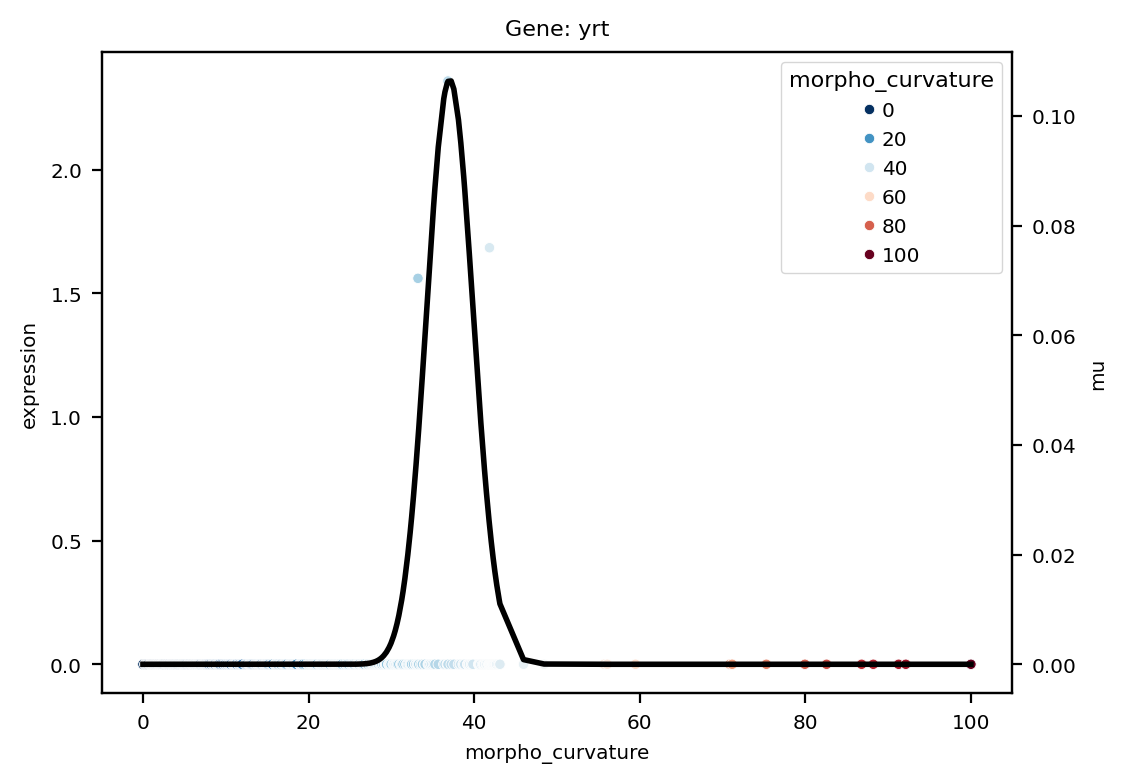

(<Figure size 600x400 with 2 Axes>,
 [<AxesSubplot:xlabel='morpho_curvature', ylabel='mu'>])

In [8]:
st.pl.glm_fit(
    adata=adata,
    genes=["yrt"],
    ncols=5,
    feature_x=key,
    feature_y="expression",
    glm_key="glm_degs",
    save_show_or_return="all",
    color_key=key,
    color_key_cmap="RdBu_r",
    save_kwargs=dict(path=os.path.join(out_image_path, f"amnioserosa_{key}_glm_degs_fit"), prefix=None, ext="pdf", dpi=300)
)

In [9]:
selected_genes = ["abd-A", "osp", "TBPH", "CG32856", "CCHa1-R", "Ras85D", "nrv2", "bnb",
                  "Aladin", "EndoGI", "Myo81F", "Mcm7", "gcl", "sti", "Dpit47", "Fib"]
glm_data = glm_data.loc[selected_genes, :]
glm_data.to_csv(os.path.join(out_image_path, f"CNS_{key}_selected_glm_degs.csv"), sep="\t")
glm_data

,status,family,log-likelihood,pval,qval
abd-A,ok,NB2,-631.45640,1.486702e-11,1.353465e-10
osp,ok,NB2,-247.52194,3.714929e-09,3.378103e-08
TBPH,ok,NB2,-460.37262,8.247182e-08,1.120396e-06
CG32856,ok,NB2,-278.96494,2.377586e-07,2.154568e-06
CCHa1-R,ok,NB2,-266.41690,1.397572e-07,1.267935e-06
Ras85D,ok,NB2,-534.72860,1.410252e-06,1.269227e-05
nrv2,ok,NB2,-1085.57150,2.058871e-06,1.850874e-05
bnb,ok,NB2,-741.77454,2.750457e-09,2.170935e-05
Aladin,ok,NB2,-184.08803,5.069580e-06,6.793581e-05
EndoGI,ok,NB2,-122.91772,3.532457e-08,9.293894e-05


In [18]:
for gn in GNs:# list(glm_data.index):
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    pc_index=pc_model.point_data["obs_index"].tolist()
    exp = adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=pc_model, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.pl.three_d_plot(
        model=pc_model,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"amnioserosa_{key}_glm_degs_genes_{_gn}.pdf")
    )

KeyError: 'Itgbn'

In [12]:
for gn in ["ush", "peb", "tup", "srp"]:
    interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=gn,
                                                    target_points=np.asarray(pc_model.points), device="0",
                                                    training_iter=100)
    interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=gn,
                                                key_added=gn)
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    st.pl.three_d_plot(
        model=interpolated_gp_pc,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=0.6,
        colormap="afmhot_r",
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"amnioserosa_{key}_glm_degs_interpolated_genes_{_gn}.pdf")
    )

{'obs_keys': [], 'var_keys': ['ush']}


Minibatch: 100%|██████████| 1/1 [00:00<00:00, 69.15it/s, loss=1.92]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 55.41it/s, loss=1.88]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 112.63it/s, loss=1.85]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 52.86it/s, loss=1.82]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 75.58it/s, loss=1.79]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 70.47it/s, loss=1.75]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 69.01it/s, loss=1.7]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 70.99it/s, loss=1.67]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 70.01it/s, loss=1.65]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 70.43it/s, loss=1.63]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 69.46it/s, loss=1.61]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 90.75it/s, loss=1.59]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 63.65it/s, loss=1.56]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 87.94it/s, loss=1.55]

Minibatch: 100%|██████████| 1/1 [0

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [113.9713s]
{'obs_keys': [], 'var_keys': ['peb']}


Minibatch: 100%|██████████| 1/1 [00:00<00:00, 81.78it/s, loss=1.96]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 51.38it/s, loss=1.92]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 86.12it/s, loss=1.89]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 89.30it/s, loss=1.85]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 72.41it/s, loss=1.82]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 78.85it/s, loss=1.79]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 129.51it/s, loss=1.76]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 92.99it/s, loss=1.71]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 127.05it/s, loss=1.69]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 59.01it/s, loss=1.66]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 124.18it/s, loss=1.64]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 93.01it/s, loss=1.62]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s, loss=1.6]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 94.07it/s, loss=1.59]

Minibatch: 100%|██████████| 1/1 

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [1.9070s]
{'obs_keys': [], 'var_keys': ['tup']}


Minibatch: 100%|██████████| 1/1 [00:00<00:00, 69.30it/s, loss=1.96]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s, loss=1.92]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 113.33it/s, loss=1.88]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 125.89it/s, loss=1.85]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 123.51it/s, loss=1.82]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 94.69it/s, loss=1.79]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 91.98it/s, loss=1.76]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 130.07it/s, loss=1.74]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 123.26it/s, loss=1.7]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 96.25it/s, loss=1.68]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 58.03it/s, loss=1.66]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s, loss=1.64]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 115.78it/s, loss=1.62]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 54.69it/s, loss=1.61]

Minibatch: 100%|██████████| 1

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [2.4806s]


{'obs_keys': [], 'var_keys': ['srp']}


Minibatch: 100%|██████████| 1/1 [00:00<00:00, 91.73it/s, loss=1.96]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 54.86it/s, loss=1.93]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s, loss=1.89]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 121.01it/s, loss=1.86]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 122.08it/s, loss=1.83]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 99.48it/s, loss=1.8]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 77.39it/s, loss=1.77]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 82.66it/s, loss=1.74]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 83.16it/s, loss=1.69]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 63.54it/s, loss=1.67]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 86.81it/s, loss=1.65]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 67.95it/s, loss=1.62]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 77.35it/s, loss=1.61]

Minibatch: 100%|██████████| 1/1 [00:00<00:00, 78.83it/s, loss=1.59]

Minibatch: 100%|██████████| 1/1 

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [1.7265s]


In [22]:
germ_adata = st.read_h5ad(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_E7_8h_germ_layer_new/h5ad/{sample_id}_germband_v3.h5ad")
adata = germ_adata[germ_adata.obs["anno_tissue_new"] == "CNS", :]
adata.X = adata.layers["X_counts"].copy()
adata = adata[adata.X.sum(axis=1)!=0, adata.X.sum(axis=0)!=0]
adata = adata[:, ~adata.var.index.str.startswith(f"mt:")]
adata

In [23]:
sc.pp.normalize_total(adata, target_sum=5e3)
sc.pp.log1p(adata)

In [24]:
tissue_pc, _ = st.tdr.construct_pc(
    adata=adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue_new",
    key_added="tissue",
    colormap={"amnioserosa": "#bdcf32", "CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "salivary gland": "#ef9b20",},
)

In [25]:
for gn in selected_genes:# list(glm_data.index):
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    pc_index=tissue_pc.point_data["obs_index"].tolist()
    exp = adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=tissue_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.pl.three_d_plot(
        model=tissue_pc,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"CNS_{key}_glm_degs_genes_{_gn}.pdf")
    )

In [27]:
for gn in selected_genes:
    interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=gn,
                                                    target_points=np.asarray(tissue_pc.points), device="0",
                                                    training_iter=100)
    interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=gn,
                                                key_added=gn)
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    st.pl.three_d_plot(
        model=interpolated_gp_pc,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=0.6,
        colormap="afmhot_r",
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"CNS_{key}_glm_degs_interpolated_genes_{_gn}.pdf")
    )